In [1]:
from SonicBatt import utils
import os
import pandas as pd
import pyarrow.parquet as pq
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

root_dir = utils.root_dir()
study_path = os.path.join(root_dir, 'studies', 'degradation')
data_path = os.path.join(study_path, 'Raw Data')
visualistion_path = os.path.join(study_path, 'Visualisation')
ancillary_data_path = os.path.join(study_path, 'Ancillary Data')

database = pd.read_excel(os.path.join(data_path, 'database.xlsx'))
rate_tests = database.loc[database['test_type']=='multi_c_rate'].reset_index(drop=True)

c_rates = [0.2, 0.5, 0.75, 1]

# Plot font settings
ticksize=8
mpl.rc('xtick', labelsize=ticksize)
mpl.rc('ytick', labelsize=ticksize)
mpl.rc('axes', titlesize=12, labelsize=10) # --> labelsize also acts on colorbar label.
mpl.rc('legend', fontsize=8, title_fontsize=10)
mpl.rc('lines', linewidth=0.8, markersize=1)


In [2]:
# Identify Acoustic Peaks
parquet_filename = 'Multi_c_rate_tests.parquet'
parquet_filepath = os.path.join(ancillary_data_path, parquet_filename)
if not os.path.exists(ancillary_data_path):
    os.makedirs(ancillary_data_path)
if not os.path.exists(parquet_filepath):
    # Find peaks and savethem
    for i in range(len(rate_tests)):
        print('{} out of {}'.format(i, len(rate_tests)))
        test_id = rate_tests['test_id'].iloc[i]
        test_dir = os.path.join(data_path, test_id)
        temp_df = utils.df_with_peaks(data_path, test_id, passes=200)
        temp_df = temp_df[['cycling', 'peak_tofs', 'peak_heights']]
        temp_df[('cycling', 'test_id')] = test_id
        if i == 0:
            df = temp_df
        else:
            df = pd.concat([df, temp_df], axis=0)
    # Save the concatenated file
    df.to_parquet(parquet_filepath)
else:
    df = pq.read_table(parquet_filepath).to_pandas()


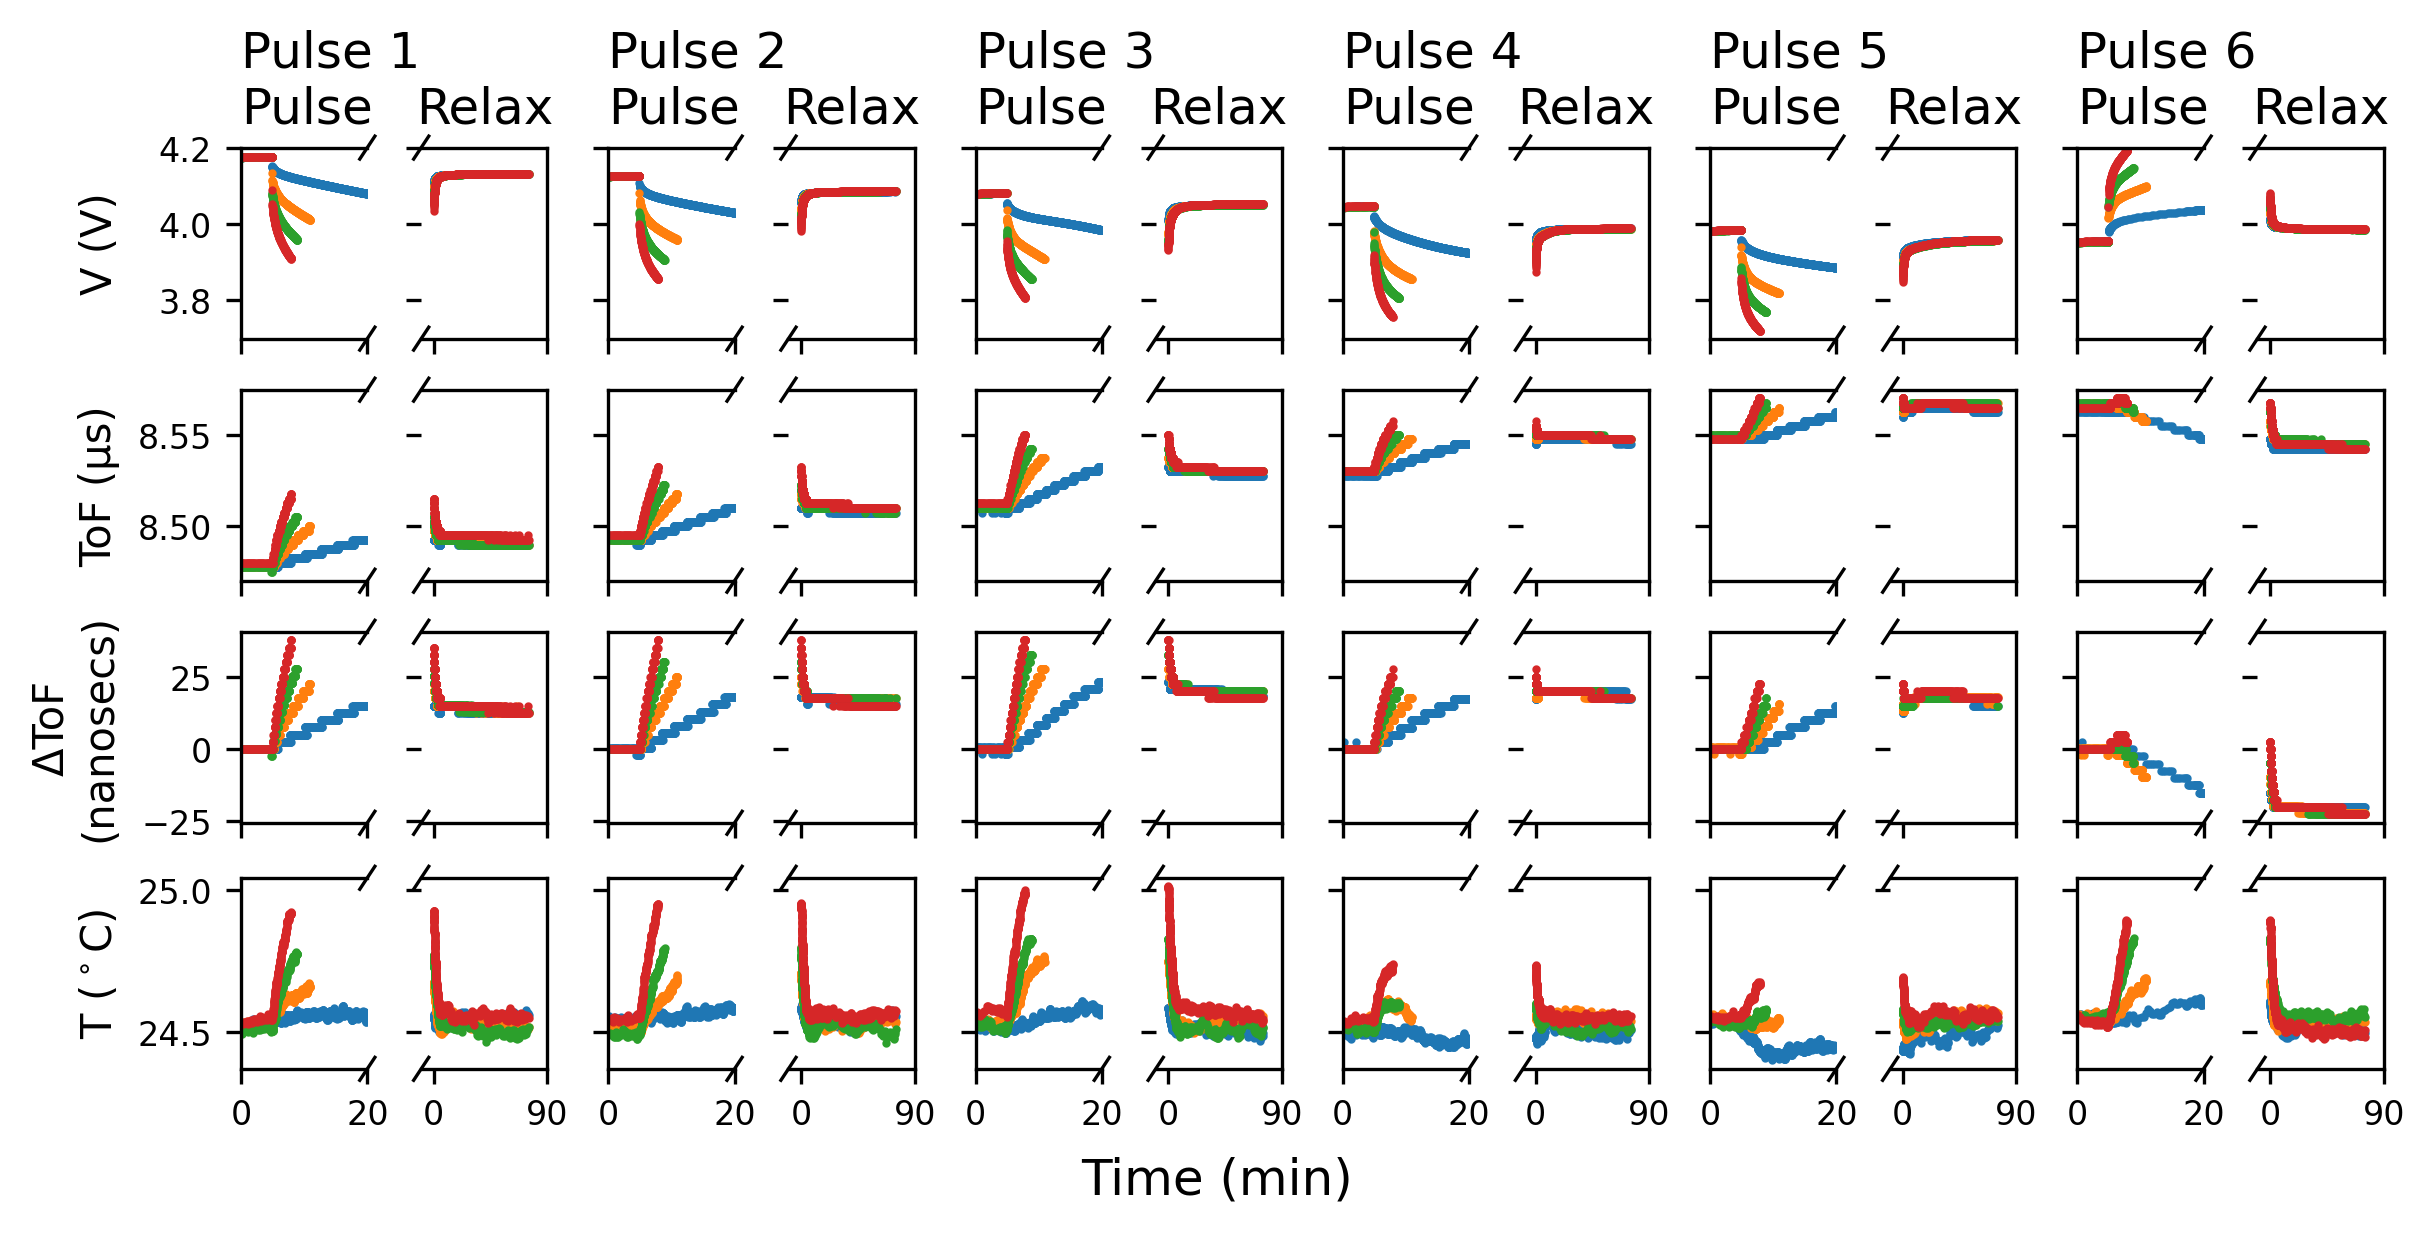

In [3]:
# Plot pulse-relax grid
f, axs = plt.subplots(4, 12, sharex='col', sharey='row',
                    figsize=(8,4), dpi=300, constrained_layout=True)
f.patch.set_facecolor('white')

for i, c_rate in enumerate(c_rates):
    Peak = -1
    s=1
    filter = rate_tests['c_rate'] == c_rate
    test_id = rate_tests.loc[filter, 'test_id'].iloc[0]
    test_dir = os.path.join(data_path, test_id)
    filter = df[('cycling', 'test_id')] == test_id
    sub_df = df.loc[filter].reindex()
    Protocol_objects = utils.create_custom_object(test_id, test_dir)
    #
    def plot_signals(acoustic_pulse_list, ax_offset = 0):
        for j, Pulse_id in enumerate(range(len(acoustic_pulse_list))):
            acoustic_pulse = acoustic_pulse_list[Pulse_id]
            R_pre_start_ind = acoustic_pulse.R_pre_start_ind
            R_pre_end_ind = acoustic_pulse.R_pre_end_ind
            C_end_ind = acoustic_pulse.C_end_ind
            R_post_start_ind = acoustic_pulse.R_post_start_ind
            R_post_end_ind = acoustic_pulse.R_post_end_ind
            #
            for k, my_range in enumerate([range(R_pre_start_ind, C_end_ind+1),
                                        range(R_post_start_ind, R_post_end_ind+1)]):
                filter2 = sub_df.index.isin(my_range) # i.e. all the data for this pulse object.
                df_pulse = sub_df.loc[filter2]
                time = df_pulse['cycling'].loc[:, 'Time(s)'].to_numpy()
                time = time - 2*time[0]+time[1] # shift time so it doesn't start at zero but at the vale of the first timestep.
                time /= 60 # Converting to minutes
                V = df_pulse['cycling'].loc[:, 'V(V)'].to_numpy()
                tofs = df_pulse['peak_tofs'].to_numpy()[:, Peak]
                tofs_pre_mean = np.average(tofs[:(R_pre_end_ind-R_pre_start_ind)])
                if k == 0:
                    tofs_pre_mean_0 = tofs_pre_mean
                temperature = df_pulse['cycling'].loc[:, 'Temp(degC)'].to_numpy()
                #
                if (j == 0):
                    label='{} C'.format(c_rate)
                else:
                    label=None
                
                axs[0, (j+ax_offset)*2+k].scatter(time, V, s=s, label=label)
                axs[1, (j+ax_offset)*2+k].scatter(time, tofs, s=s, label=label)
                # Get delta tof as nanosecs
                axs[2, (j+ax_offset)*2+k].scatter(time, (tofs-tofs_pre_mean_0)*1000, s=s, label=label)
                axs[3, (j+ax_offset)*2+k].scatter(time, temperature, s=s, label=label)

    # Discharge data
    acoustic_pulse_list = Protocol_objects.Acoustic_char_dischrg_seq.Acoustic_Pulse_list    
    plot_signals(acoustic_pulse_list, ax_offset = 0)
    # Charge data
    acoustic_pulse_list = Protocol_objects.Acoustic_char_chrg_seq.Acoustic_Pulse_list    
    acoustic_pulse_list = [acoustic_pulse_list[0]] # Get only the 1st charging pulse
    plot_signals(acoustic_pulse_list, ax_offset = 5)

# Add broken axis lines // between pairs of axes
d = .06 # how big to make the diagonal lines in axes coordinates
for i in range(axs.shape[0]):
    for j in range(6):
        axs[i, 2*j].spines['right'].set_visible(False)
        axs[i, 2*j+1].spines['left'].set_visible(False)
        # arguments to pass plot, just so we don't keep repeating them
        kwargs = dict(transform=axs[i, 2*j].transAxes, color='k', clip_on=False)
        axs[i, 2*j].plot((1-d,1+d),(-d,+d), **kwargs) # top-left diagonal
        axs[i, 2*j].plot((1-d,1+d),(1-d,1+d), **kwargs) # bottom-left diagonal
        #
        kwargs.update(transform=axs[i, 2*j+1].transAxes) # switch to the bottom axes
        axs[i, 2*j+1].plot((-d,d),(-d,+d), **kwargs) # top-right diagonal
        axs[i, 2*j+1].plot((-d,d),(1-d,1+d), **kwargs) # bottom-right diagonal

axs[0,0].set_ylabel('V (V)')
axs[1,0].set_ylabel('ToF (μs)')
axs[2,0].set_ylabel('ΔToF\n(nanosecs)')
axs[3,0].set_ylabel('T ($^\circ$C)')
for j in range(6):
    axs[0,j*2].set_title('Pulse {}\nPulse'.format(j+1), loc='left')
    axs[0,j*2+1].set_title('Relax', loc='center')
    axs[-1,j*2].set_xlim(0, 20)
    axs[-1,j*2+1].set_xlim(-10, 90)
    axs[-1,j*2].set_xticks([0, 20])
    axs[-1,j*2+1].set_xticks([0, 90])
axs[0,0].set_ylim(3.7, 4.2)
axs[0,0].set_yticks([3.8, 4.0, 4.2])
f.supxlabel('Time (min)')

f.align_ylabels()

save_filename = 'c_rates_pulses'
utils.save_figure(f, visualistion_path, save_filename, 'png')


In [4]:
# Isolate pulses
def make_grids(Pulse_direction = 'dischrg', Peak = -1):
    """
    Pulse_direction: 'dischrg' | 'chrg'
    """
    quantities = ['times', 'voltages', 'temps', 'tofs', # Will be represented as lists
                    'pre_pulse_ocv', 'post_pulse_ocv', # Will be numbers
                    'tofs_pre_means', 'tofs_post_means', 'tofs_delta_state',
                    'tofs_rise_pct', 'tofs_overshoot_pct', 'tofs_delta_state_pct',
                    'tofs_rise', 'tofs_overshoot',
                    'temps_pre_means', 'temps_post_means',
                    'temps_rise', 'temps_overshoot'
                    ]
    if Pulse_direction == 'dischrg':
        pulse_range = range(0, 5)
    elif Pulse_direction == 'chrg':
        pulse_range = range(0, 1)   
    #
    grids = {
        quantity: [] for quantity in quantities}

    # Loop through all c_rates
    for i, c_rate in enumerate(c_rates):
        cycle_data = {
            quantity: [] for quantity in quantities}
        #
        filter = rate_tests['c_rate'] == c_rate
        test_id = rate_tests.loc[filter, 'test_id'].iloc[0]
        test_dir = os.path.join(data_path, test_id)
        filter = df[('cycling', 'test_id')] == test_id
        sub_df = df.loc[filter].reindex()
        Protocol_objects = utils.create_custom_object(test_id, test_dir)

        if Pulse_direction == 'dischrg':
            acoustic_pulse_list = Protocol_objects.Acoustic_char_dischrg_seq.Acoustic_Pulse_list
        elif Pulse_direction == 'chrg':
            acoustic_pulse_list = Protocol_objects.Acoustic_char_chrg_seq.Acoustic_Pulse_list
        # ----------------------------
        # Loop through all the pulses
        for Pulse_id in pulse_range:
            # Get acoustic pulse characteristics
            acoustic_pulse = acoustic_pulse_list[Pulse_id]
            R_pre_start_ind = acoustic_pulse.R_pre_start_ind
            R_pre_end_ind = acoustic_pulse.R_pre_end_ind
            R_post_end_ind = acoustic_pulse.R_post_end_ind
            C_end_ind = acoustic_pulse.C_end_ind
            #
            filter2 = sub_df.index.isin(range(R_pre_start_ind, R_post_end_ind)) # i.e. all the data for this pulse object.
            df_pulse = sub_df.loc[filter2]
            time = df_pulse['cycling'].loc[:, 'Time(s)'].to_numpy()
            time = time - 2*time[0]+time[1] # shift time so it doesn't start at zero but at the vale of the first timestep.
            V = df_pulse['cycling'].loc[:, 'V(V)'].to_numpy()
            tofs = df_pulse['peak_tofs'].to_numpy()[:, Peak]
            tofs *= 1000 # Convert to nanoseconds
            tofs_pre_mean = np.average(tofs[:(R_pre_end_ind-R_pre_start_ind)])
            tofs_post_mean = np.average(tofs[-20:]) # average over the last 20 points of the post-pulse relaxation.
            tofs_pulse_max = np.max(tofs[:(C_end_ind-R_pre_start_ind)])
            temperature = df_pulse['cycling'].loc[:, 'Temp(degC)'].to_numpy()
            temperature_pre_mean = np.average(temperature[:(R_pre_end_ind-R_pre_start_ind)])
            temperature_post_mean = np.average(temperature[-20:])

            # Calculate what's needed to populate cycle_data
            cycle_data['times'].append(time)
            cycle_data['voltages'].append(V)
            cycle_data['temps'].append(temperature)
            cycle_data['tofs'].append(tofs)

            cycle_data['pre_pulse_ocv'].append(V[0])
            cycle_data['post_pulse_ocv'].append(V[-1])
            cycle_data['tofs_pre_means'].append(tofs_pre_mean)
            cycle_data['tofs_post_means'].append(tofs_post_mean)
            cycle_data['tofs_rise'].append(tofs_pulse_max - tofs_pre_mean)
            cycle_data['tofs_overshoot'].append(tofs.max() - tofs_post_mean)
            cycle_data['tofs_delta_state'].append(abs(tofs_pre_mean - tofs_post_mean))

            cycle_data['tofs_rise_pct'].append(
                (tofs_pulse_max - tofs_pre_mean)/tofs_pre_mean*100)
            cycle_data['tofs_overshoot_pct'].append(
                (tofs_pulse_max - tofs_post_mean)/tofs_pre_mean*100)
            cycle_data['tofs_delta_state_pct'].append(
                (abs(tofs_pre_mean - tofs_post_mean))/tofs_pre_mean*100)

            cycle_data['temps_pre_means'].append(temperature_pre_mean)
            cycle_data['temps_post_means'].append(temperature_post_mean)
            cycle_data['temps_rise'].append(temperature.max()-temperature_pre_mean)
            cycle_data['temps_overshoot'].append(temperature.max()-temperature_post_mean)

            for quantity in ['voltages', 'temps', 'tofs']:
                try:
                    assert (len(cycle_data[quantity][-1]) == len(cycle_data['times'][-1]))
                except AssertionError:
                    print('Failed on pulse: {}'.format(Pulse_id))
                    print('Failed on quantity: {}'.format(quantity))           

        # Append data for this c_rate to the grid
        for quantity in quantities:
            grids[quantity].append(cycle_data[quantity])

    def isolate_pulse_from_grid(grid):
        grids_dfs = []
        for Pulse_id in pulse_range:
            data = {}
            data['c_rate'] = c_rates
            for quantity in quantities:
                data[quantity] = [cycle_list[Pulse_id] for cycle_list in grid[quantity]]
            grids_dfs.append(pd.DataFrame.from_dict(data = data))
        return grids_dfs
    
    return isolate_pulse_from_grid(grids)

grids_dischrg = make_grids(Pulse_direction = 'dischrg', Peak = -1)
# Although not used here, caculate grids for the first charging pulse too 
# grids_chrg = make_grids(Pulse_direction = 'chrg', Peak = -1)


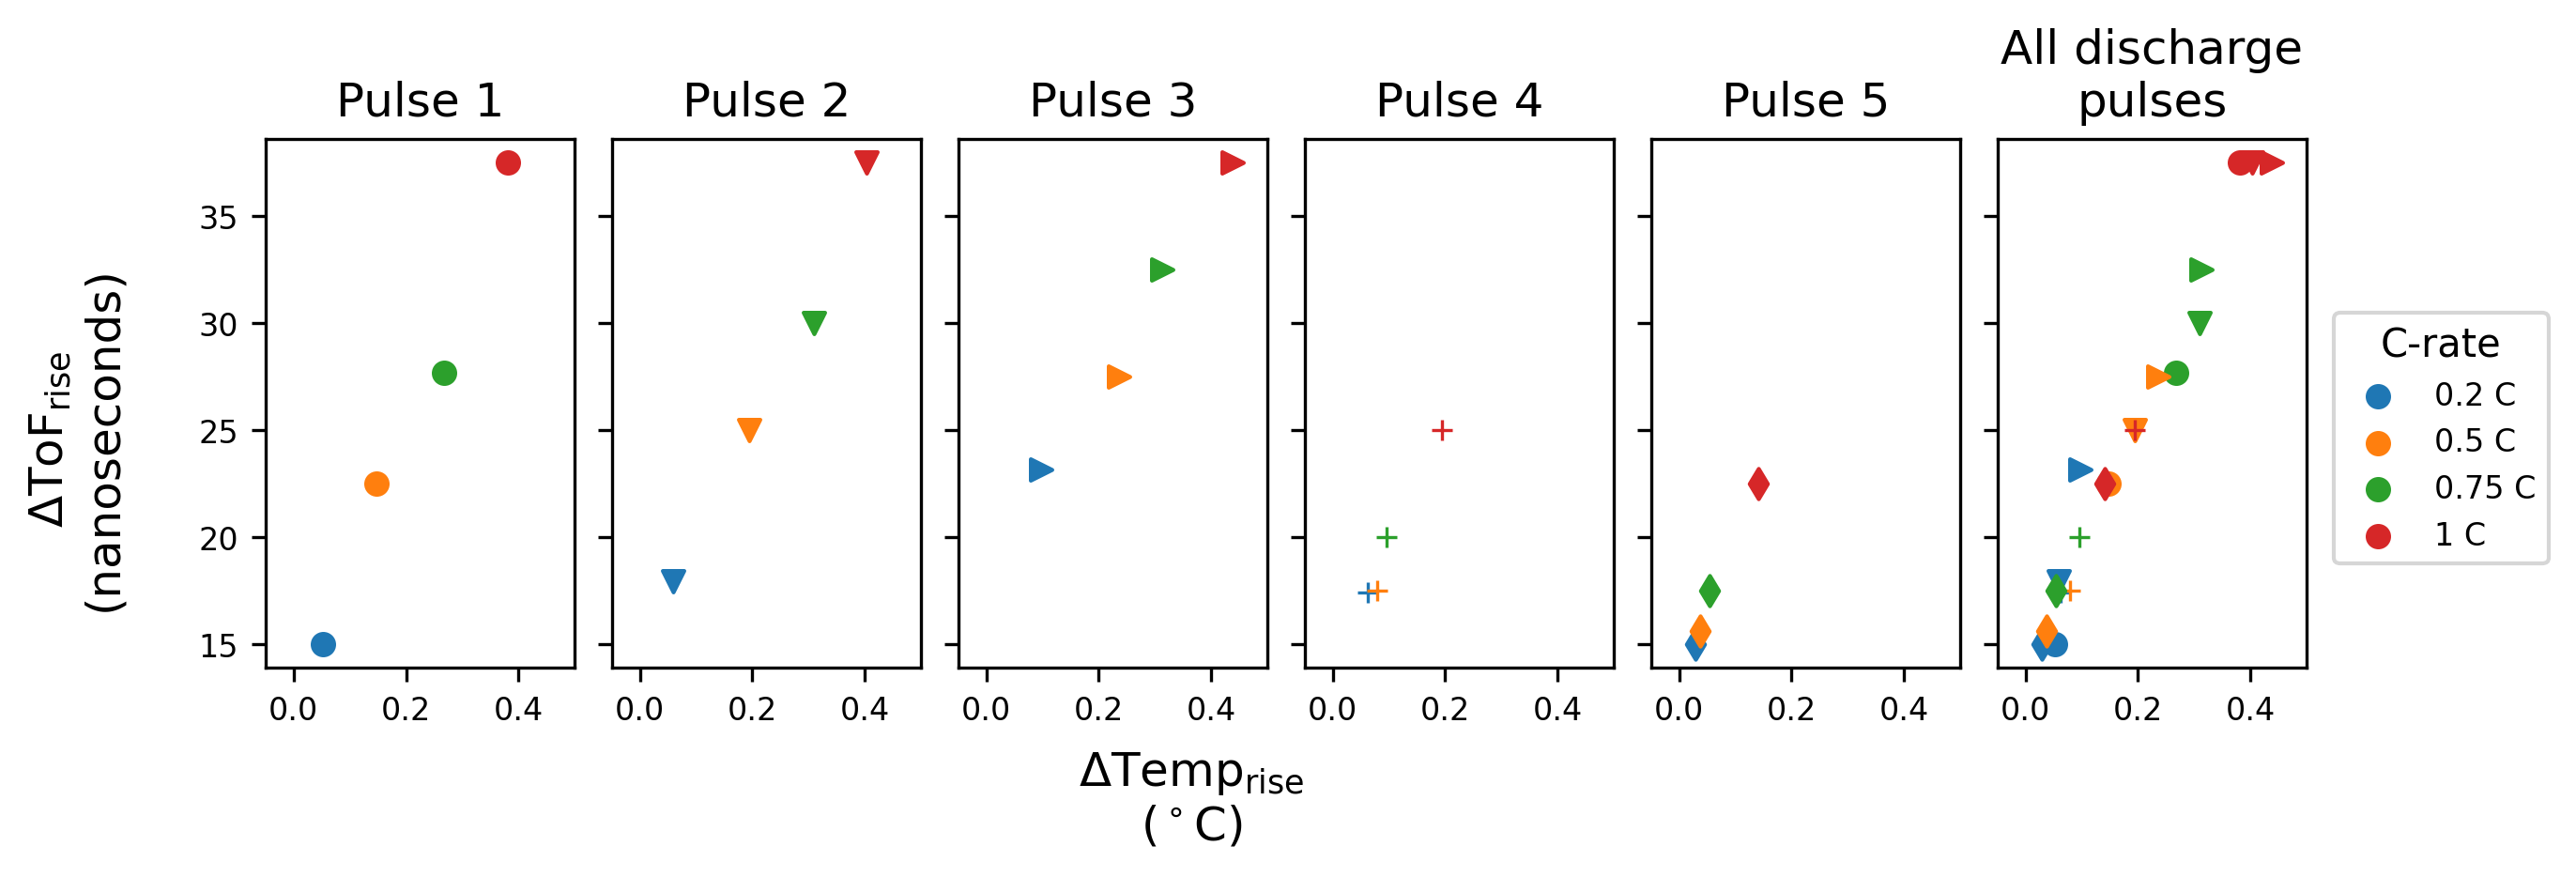

In [5]:
c_rate_cols = {
    0.2: 'tab:blue', 0.5: 'tab:orange', 0.75: 'tab:green', 1: 'tab:red'}
pulse_markers = {0: 'o', 1: 'v', 2: '>', 3: '+', 4: 'd', 5: '^'}
s=30

f, axs = plt.subplots(1,6, sharey='row', sharex=True, figsize=(8,3), dpi=300,
    constrained_layout=True)
f.patch.set_facecolor('white')
for j, Pulse_id in enumerate(range(5)):
    m = pulse_markers[j]
    for i, c_rate in enumerate(c_rates):
        if j == 0:
            label = '{} C'.format(c_rate)
        else:
            label = None
        c = c_rate_cols[c_rate]

        tofs_rise = grids_dischrg[Pulse_id].loc[i, 'tofs_rise']
        temps_rise = grids_dischrg[Pulse_id].loc[i, 'temps_rise']

        # Use tof_rise_dict | tof_overshoot_dict
        axs[j].scatter(temps_rise, tofs_rise,
            marker=m, color=c, s=s, label=label)
        axs[-1].scatter(temps_rise, tofs_rise,
            marker=m, color=c, s=s)
    axs[j].set_title('Pulse {}'.format(j+1))
    # axs[j].set_ylim(-5,40)
    axs[j].set_xlim(-0.05, 0.5)
    axs[j].set_xticks([0, 0.2, 0.4])
axs[-1].set_title('All discharge\npulses')
f.supylabel('$\mathrm{ΔToF_{rise}}$\n(nanoseconds)', va='center', ha='center')
f.supxlabel('$\mathrm{ΔTemp_{rise}}$\n($^\circ$C)')
f.legend(loc='center left', bbox_to_anchor=(1, 0.5), title='C-rate')

save_filename = 'c_rates_dToF_vs_dTemp'
utils.save_figure(f, visualistion_path, save_filename, 'pdf')


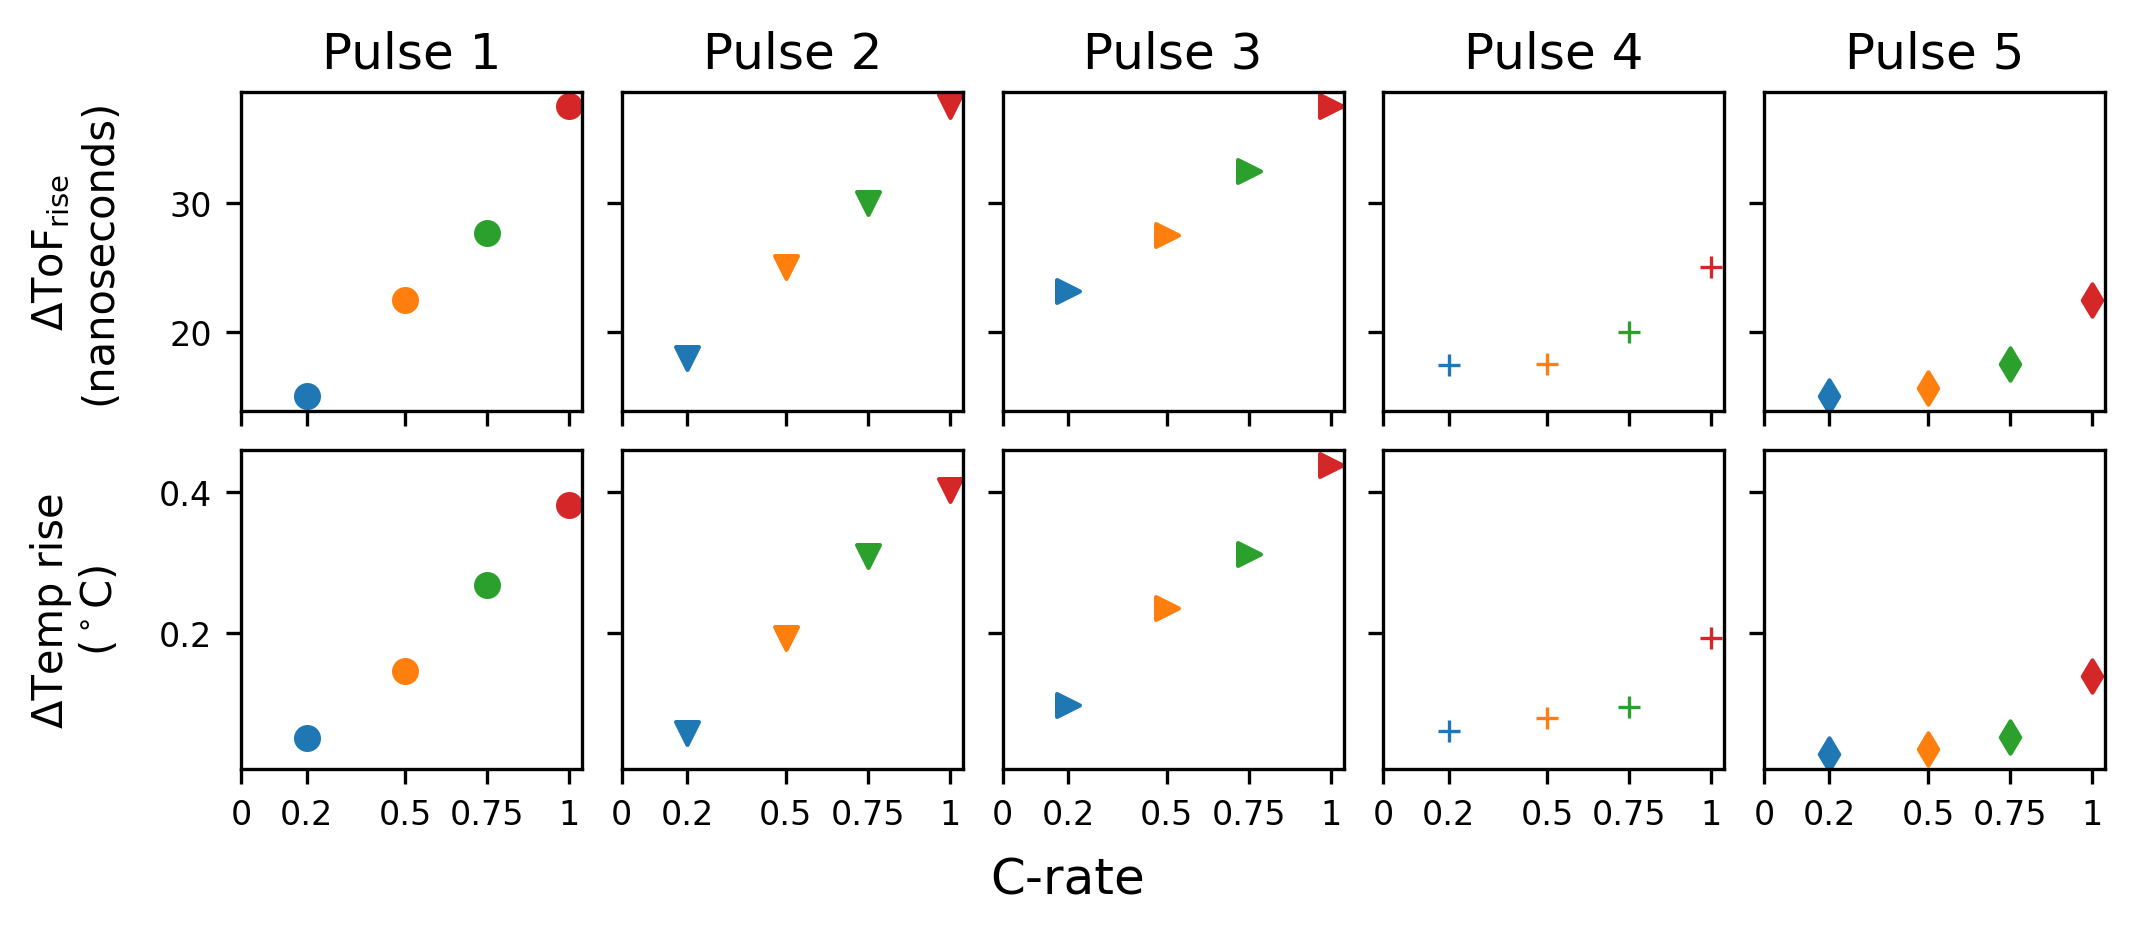

In [6]:
f, axs = plt.subplots(2,5, sharey='row', sharex=True, figsize=(7,3),
    dpi=300, constrained_layout=True)
f.patch.set_facecolor('white')
for j, Pulse_id in enumerate(range(5)):
    m = pulse_markers[j]
    for i, c_rate in enumerate(c_rates):
        if j == 0:
            label = '{} C'.format(c_rate)
        else:
            label = None
        c = c_rate_cols[c_rate]

        tofs_rise = grids_dischrg[Pulse_id].loc[i, 'tofs_rise']
        temps_rise = grids_dischrg[Pulse_id].loc[i, 'temps_rise']

        # Use tof_rise_dict | tof_overshoot_dict
        axs[0,j].scatter(c_rate, tofs_rise,
            marker=m, color=c, s=s)
        axs[1,j].scatter(c_rate, temps_rise,
            marker=m, color=c, s=s, label=label)

        axs[0,j].set_title('Pulse {}'.format(j+1))

labelpad=20
axs[0,0].set_ylabel('$\mathrm{ΔToF_{rise}}$\n(nanoseconds)',
                    va='center', ha='center', labelpad=labelpad)
axs[1,0].set_ylabel('ΔΤemp rise\n($^\circ$C)',
                    va='center', ha='center', labelpad=labelpad)
axs[0,0].set_xticks([0, 0.2, 0.5, 0.75, 1])
axs[0,0].set_xticklabels([0, 0.2, 0.5, 0.75, 1])
f.align_ylabels()
f.supxlabel('C-rate')

save_filename = 'c_rates_deltas_vs_rate'
utils.save_figure(f, visualistion_path, save_filename, 'png')
